In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
import sklearn

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [42]:
#setup input and output formats, load data

file_name = "PLN7.csv"
id_cols =["db_id","sample_id"]
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path('D:/workspace/lazydeep/experiments/2.03/')

data_file = data_path / file_name
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

#preprocessing = StandardScaler()
preprocessing = PLSRegression(n_components=22) #22 36 63 34

In [43]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)

dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(10000, 129)


475.939532629375


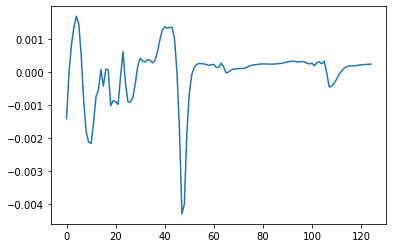

In [46]:
X,y = dataset[:]
print(np.var(y))

summ =  ut.take_summary(X)['median']

fig, ax = plt.subplots()

ax.plot(summ[0:len(summ)-1])
#ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(Path("D:/workspace/lazydeep/data/soil_data/")/f"PLN7_median.png",bbox_inches='tight')

In [4]:
model_num = "random_77"
k = 200
#voting = 'distance'
predictor = f"lwr_k={k}"
lazy_predictors = {predictor:LocalWeightedRegression(k,kernal=True)}
#{predictor:LocalWeightedRegression(k,kernal=True)}

In [5]:
model_names = [model_num]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}

fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
eval_ = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

In [6]:
device = "cpu"
tb = None 
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval_.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

In [7]:
print(deep_scores_final)
print(f"SD AE: {np.std(np.abs(deep_preds_final['y']-deep_preds_final[model_num]))}")

{'MSE': {'random_77': 19.545274433932843}, 'R2': {'random_77': 0.9728380032941447}}
SD AE: 3.1797844410210523


In [8]:
lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = lazy_predictors,loss_fun_sk = mean_squared_error)
lwr_scores_final, lwr_preds_final, _ , _, _,_= eval_.build(deep_models,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)


In [9]:
print(lwr_scores_final)
print(f"SD AE: {np.std(np.abs(lwr_preds_final['y']-lwr_preds_final[predictor]))}")

{'MSE': {'lwr_k=200': 17.91759842401228}, 'R2': {'lwr_k=200': 0.975099978895706}}
SD AE: 3.105132475886647
